In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Datasets import load
from torch.utils.data import DataLoader
from model import Conv_Net_Dropout, Conv_Net_FC_Dropout
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [2]:
model = Conv_Net_FC_Dropout()
model.load_state_dict(torch.load('/home/julius/OOD/models/model3_drop_fc_0_5.pth'))
model.to('cuda')
model.fcs = model.fcs[:-1]
model.eval()

Conv_Net_FC_Dropout(
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
  )
  (fcs): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [4]:
def energy(logits, T = 1):
    return -T * torch.logsumexp(logits / T, dim = 1)

In [5]:
mnist_dataset = load('MNIST')(train = False)
mnist_loader = DataLoader(mnist_dataset, batch_size = 128, shuffle = False)

cifar_dataset = load('CIFAR10')(train = False)
cifar_loader = DataLoader(cifar_dataset, batch_size = 128, shuffle = False)

Files already downloaded and verified


In [6]:
with torch.no_grad():
    mnist_logits = []
    for x, y in tqdm(mnist_loader):
        x = x.to('cuda')
        logits = model(x)
        mnist_logits.append(logits.cpu())
    mnist_logits = torch.cat(mnist_logits).numpy()

100%|██████████| 79/79 [00:00<00:00, 121.75it/s]


In [7]:
with torch.no_grad():
    cifar_logits = []
    for x, y in tqdm(cifar_loader):
        x = x.to('cuda')
        logits = model(x)
        cifar_logits.append(logits.cpu())
    cifar_logits = torch.cat(cifar_logits).numpy()

100%|██████████| 79/79 [00:00<00:00, 92.24it/s]


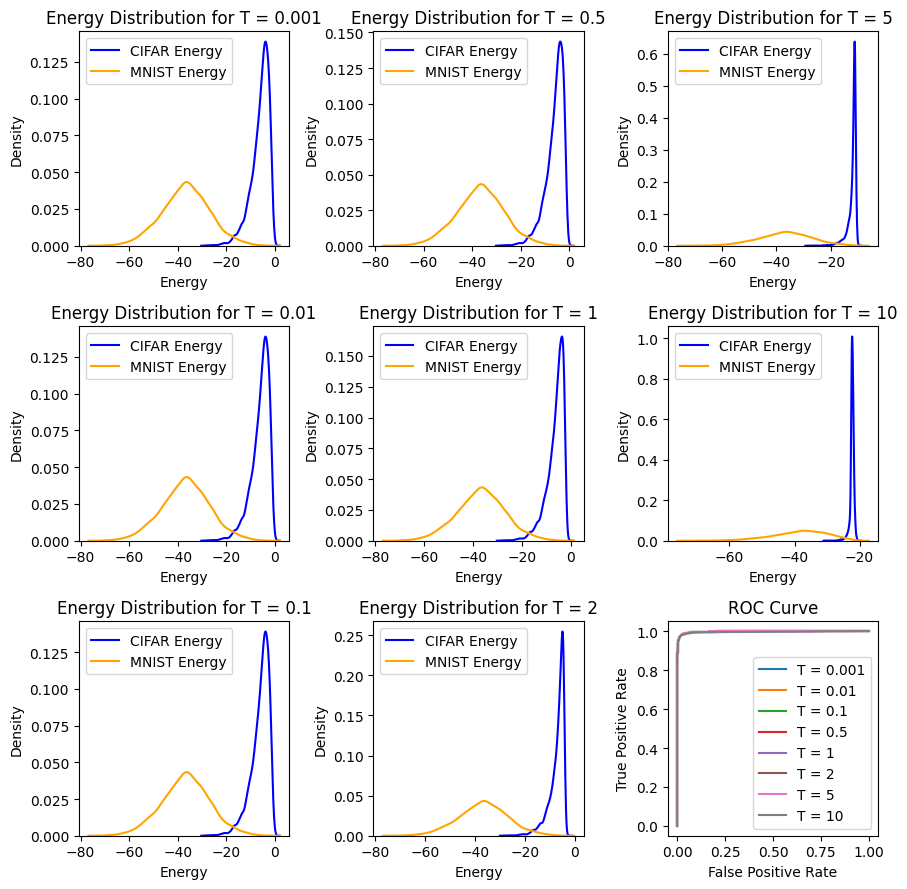

In [8]:
aucs = {}
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i,T in enumerate([0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]):
    cifar_energy = energy(torch.tensor(cifar_logits), T = T).numpy()
    mnist_energy = energy(torch.tensor(mnist_logits), T = T).numpy()
    fpr,tpr, thresholds = roc_curve(np.concatenate((np.zeros_like(cifar_energy),np.ones_like(mnist_energy))),np.concatenate(( -cifar_energy, -mnist_energy)))
    aucs[T] = auc(fpr, tpr)

    ax[2, 2].plot(fpr, tpr, label = f'T = {T}')
    sns.kdeplot(cifar_energy, color='blue', ax=ax[i%3, i//3], label='CIFAR Energy')
    sns.kdeplot(mnist_energy, color='orange', ax=ax[i%3, i//3], label='MNIST Energy')
    ax[i%3, i//3].set_xlabel('Energy')
    ax[i%3, i//3].set_ylabel('Density')
    ax[i%3, i//3].set_title(f'Energy Distribution for T = {T}')
    ax[i%3, i//3].legend()
ax[2,2].set_xlabel('False Positive Rate')
ax[2,2].set_ylabel('True Positive Rate')
ax[2,2].set_title('ROC Curve')
ax[2,2].legend()
plt.tight_layout()
plt.show()


In [9]:
for key in aucs.keys():
    print(f'T = {key} AUC = {aucs[key]}')

T = 0.001 AUC = 0.9976427000000001
T = 0.01 AUC = 0.99764274
T = 0.1 AUC = 0.9976437400000001
T = 0.5 AUC = 0.99765954
T = 1 AUC = 0.9976917900000001
T = 2 AUC = 0.9977598400000002
T = 5 AUC = 0.9977582899999999
T = 10 AUC = 0.99509955
